At Columbia (Dec 12, 2019), we agreed to take another stab at the data.  This time, instead of pure
regression, we are going to make it more of multiclass problem, or what I'd call a
"binned regression" since the binned variable is still ordinal, etc.

Basically, 
* only keep babies that a born >= 25 weeks
    -the assumption is a clinician
     is running the model at the end of week 24 / beginning of week 25
* then only predict in 5 wk bins
    - 25 to 29 wks
    - 30 - 34 wks
    - 35+ wks

This should be helpful since we did find that we could only really make
predictions within +/- 7 days of the actual birth.

**Other Lessons Learned**: Another thing we found out is that there are many pregnancies
that are enrolled/registered into the program any time between 1 week GA to beyond 30 weeks GA.  The
implications are frightening: most of the "first appointment" variables, like BMI, are collected
at this point of enrollment/registration.  This is counter to our assumption that the first appointment
was within the first several weeks of a pregnancy... Since this is not the case, BMI is no longer
a metric for pre/early pregnancy health and weight; instead, it is confounded by the natural
weight gain that occurs during pregnancy (i.e., a component of BMI is correlated with how far into
the pregnanacy the woman has made it thus far).  Dani is spending time, working more closely with
our teammates at Columbia, to better filter out bad data.  For example, BMI is not technically
a bad variable if we only allow women who attended their first appointment within, say, the
first 10 weeks of pregnancy.

     
------------------------------------

## Jan 6, 2019
In the intervening time, Dani has helped put together a v4 of the data dictionary.  Here is a list
of things that have been decided that help paint where this project is going:
* Dani worked on preparing the dataset over the holiday break
    - she asked Nico to remind her what CCGA stands for
    - she went without excluding BMI and GA at recruitment
    - the goal is to only use data before week 25
    - she told Columbia that we will try to predict labor day (knowing it will likely not work), then 
      move on to a binary classification (delivery before or after 28 week)
      * notably, she left out the binned regression concept, which is something I still think we should do
    - she asked Nico for his most recent alcohol-smoking imputed data
    - she asked David and Nico to look over her v4 list of variables for approval/rejection
* David responded about CCGA: "CCGA is the Gestational Age (days) calculated by Clinical Coordinator at recruitment."
* Nico responded about CCGA: 
    - CCGA is variable "C" from table "ADELIG" with definition "GA (days) calculated by CC at recruitment"
    - Why CCGA: "We thought that could have been a good variable to start screening for those subject enrolled in 
      the study later before (or after) 25 weeks."
* Notes about the v4 data dictionary (from Dani):
    - In the Excel file, the colors indicate if a variable is a predictor (green) or something else (magenta), where
      "something else" can be a target variable or a stratification/cutoff variable (magenta)
    - there is a column that says if a variable is included in our final data set or not (it should match 
      colored variables, but trust the column if there is a discrepancy)
* Nico helped update v4 data dictionary 
    - added his updated alcohol/smoking vars
    - noted several potentially concerning vars that might represent a potential for data leakage
        * Methamphetamine Use in Trimester 2 (15 to 28 Weeks)
        * Marijuana Use in Trimester 2 (15 to 28 Weeks)
        * Other Drug Use in Trimester 2 (15 to 28 Weeks)
        * T2_Alc: this variable integrates over the entire T2 trimester, so if the simulated
          real case scenario is a visit at 25 weeks of GA, then these numbers are not necessarily
          accurate... **NOTE2SELF: I think we can transform the T2_Alc variable into "weekly average during T2”
          by dividing it by 13, which is something that could still be derived by a clinician at 25 weeks 
          (though in this case, the sum would be divided by 10), thus be available at the time of prediction.**
          

In [1]:
import pandas as pd
import numpy as np

In [86]:
!ls ../data/raw

BISH FETAL GA ASSESSMENT_DB.csv
BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv
BISH_Test
Derived Variables of Interest Participants Only.mental_ill_DB.csv
Fetal_Toitu_Physio_Features_Early_Signal_093019.csv
Maternal HR XFER 052318.csv
adafppappa_DB.csv
adalc_patid_DB.csv
adcdrisc_DB.csv
addrg_patid_DB.csv
adedin_merged_edit_bish_DB.csv
adelig_DB.csv
adfetalgrowth_BISHCORRECTED_01.24.19_persex_DB.csv
admh_DB.csv
adptsd_DB.csv
adsc_DB.csv
adscmat_DB.csv
adsmk_patid_DB.csv
adstai_DB.csv
advs_DB.csv
maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv
mbh001_Dictionary-of-Variable-terms_20200102_V4_NicoPini.xlsx


In [302]:
# ADAFPPAPPA
# V3 Update:  
#   * all vars the same
#   * Dani fixed missing value representation (-9999.99 --> -999999)
#     - no longer need: 
#       adafppappa.afpmom = adafppappa.afpmom.\
#           map(lambda x: -999999 if x == -9999.99 else x)
# V4 Variable Updates: None. (PATID, AFPMoM)

# ADALC 
# V3 Update: 
#   * use_cols: range(0,12) --> v3_adalc_vars
# V4 Variable Updates:
#   * No longer using anything from this database
#   * Instead, we are using Nico's imputed alcohol database

# ADCDRISC
# V3 Update:
#   * no longer need to set na_values='#NULL!' in read_csv (Dani fixed file)
#     - the file formerly contained on bad value like this; now it doesn't
#     - this obviates the need for the adcdrisc.fillna() command as well
#   * all vars the same though
# V4 Variable Updates:  None (patid, cdrisc_raw)

# ADDRG 
# V3 Update:
#   * following vars no longer included from the outset:
#     - 'Hair1YrPrior6', 'HairLMP2', 'HairT12', 'HairT22',
#       'Hookah1YrPrior6', 'HookahLMP2', 'HookahT12', 'HookahT22',
#       'MJ1YrPrior6'
#    * this means the "drop cols" list is slightly smaller as well
#-----
# It is essentially necessary to drop: 
#     hair1yrprior6 (0 nznn), hairlmp2 (0 nznn), hairt12 (0), hairt22 (2)
# It is likely necessary to drop: 
#     otherlmp2 (2 nznn instances)
# It might be worth dropping:
#     othert12 (14 nznn), othert22 (16), other1yrprior2 (20), methlmp2 (54)
# addrg_drop=False
# if addrg_drop:
#     addrg_drop_cols = ['otherlmp2','othert12','othert22','other1yrprior2','methlmp2']
#     addrg.drop(addrg_drop_cols, axis=1, inplace=True)
# NOTE: nznn := nonzero/nonNull values
#------
# V4 Variable Updates: None 



# ADEDIN (merged edit bish)
# V3 Update:
#   * no updates necessary (same vars, same code)
#     - this means that Dani did not find and fix the single NaN in the file
#-----------
#  -- Do we want to keep the Endinburgh CycleID? (Bill recommneds not to, while
#     Dani thinks it can serve as a source of interaction information, e.g., within
#     a RF)
#---------
# V4 Variable Updates: 
#  -- None (Edinburgh_Raw, Cycle_Id)
#  -- However: Dani created two variables in the ADEDIN table, but named them differently in the data  
#     dictionary (var_name) versus the data table file (var_name_db).  These two vars have been corrected 
#     in this file so that the variable names are the same in both files:  (i) EDINBURGH_Raw_All-10-15-20_db, 
#     and (ii) CycleID_All-10-15-20_db




# ADELIG
# V3 Update:
#   * Vars: MAT_AGE, RACEAI4, RACENIH7
#     - i.e., no hispanic2 var, etc
#------
# V4 Variable Updates:
#  * we now include CCGA, which is a GA estimated by a clinician at
#    the time of a woman's first appointment/registration in the study
#    - we assumed all women were enrolled/registered within the first few weeks
#      of their pregnancy, but we were wrong
#    - this enrollment/registration can happen at any point during a woman's pregnancy,
#      e.g., if they first come in at 33 weeks, then this is when they register and
#      a bunch of data gets collected
#    - there are vars that this affects, e.g., BMI, which is now confounded by
#      the natural growth during the pregnanacy
#    - the approach Dani has opted for is to NOT use BMI (and other offending vars)
#        * to ensure no data leakage, we have to use this variable to filter out any women
#          who enroll/register after 25 weeks; this variable should then be discarded
#    - another approach could be to use this variable to only look at women who had
#      their enrollment/registration within first (say) 10 weeks of GA


# ADFETALGROWTH
# V3 Update:
#   * No changes necessary (same vars)
#----------
# V4 Variable Updates
#  * at first, the vars did not change (patid, fetussex, deviationindex)
#  * however, I edited the data dictionary, which recorded
#    the variable "FetusSex" simply as "Sex", while the data table itself
#    uses "FetusSex"
#  * then I remembered: FetusSex is redundant with GENDER2 from ADSC, so
#    I further edited the data dictionary to un-flag FetusSex
#  * SUMMARY: FetusSex has been removed.


# ADMH
# V3 Update:
#   * added final list of vars and use `usecols` parameters in `read_csv`, 
#     obviating need for dropping any cols
#-----------
#  -- NOTE:  Each of the var listed below have less than 50 nonZero/nonNull instances (out of nearly 7k records):
#       'hxsuid2', 'hxsids2', 'hxsidssuid2', 'hx_baby_cleft2', 'hx_baby_down2',
#       'hx_baby_fas2', 'hx_baby_pfas2', 'hx_baby_heart2',
#       'hx_baby_hypoxiaencep2', 'hx_baby_iugrsga2', 'hx_baby_retard2',
#       'hx_baby_neuraltube2', 'hx_baby_poorweight2', 'hx_baby_shoulder2',
#       'sicklecellanemiaprior2', 'apsprior2', 'anxietyprior2',
#       'bloodclotprior2', 'cancerprior2', 'connectivetissuedisorderprior2',
#       'gdmprior2', 'gdmpriorfp2', 'hyperthyroidprior2', 'hypothyroidprior2',
#       'lupusprior2', 'abruptionprior2', 'abruptionpriorfp2',
#       'placentapreviaprior2', 'placentapreviapriorfp2', 'ppromprior2',
#       'pprompriorfp2', 'raprior2', 'thromboembolicdiseaseprior2'
#  -- most of the vars have less than 10% (~700) nznn values
#--------
# Note that in Dani's data dict there is the varConnectiveTissueDisorderPrior2, but the var name 
#     in the data table it is actually ConnectivetissuedisorderPrior2 (fewer capitals)
#--------
# V4 Update:
#   - None
#   - Proof: set(['admh_'+item.lower() for item in v3_admh_cols]).difference(['admh_patid']).difference(use_cols)
#


# ADPTSD
# V3 Update:
#   * cols changed a bit
#   * Dani removed all non-BISH patients from file, so it is no
#     longer necessary to do so here
#   ** removed corresponding code:
#         bish_index = adptsd.patid.str.\
#             split('-').map(lambda x: x[1]) == 'BISH'
#         adptsd = adptsd[bish_index].reset_index(drop=True).dropna()
#----------------
#  -- MY REC:  DO NOT USE THIS STUFF AT ALL (here just in case we decide to)
# V4 Variable Updates:  
#   * None
#   * Still recommend throwing this out for now (maybe in the future more of this
#     data will be routinely collected)



# ADSC
# V3 Update:
#   * a few additional targets were added (Cesarean2, DLVRY_DT, DLVRYGA_DYS_SBadj)
#   * code: twin removal is no longer done here; turns out that the outer
#       joins we do later just add them back in.  Moral: remove twins after all
#       outer joins take place.
#-----------------
#  -- THIS HAS 50 DUPLICATED PATIDs due to twins...
#  -- Udi dropped these...and for the time being, I suggest we do the same, since
#     it basically serves as doubling up data points (there is no twin-tuned sensor
#     data for example;  the only var that might change is gender).
#  -- NOTE: I added a few potential target vars that Dani didn't include in
#     her greenlit vars, namely: 'DLVRYGA_DYS', 'Preterm2', 'DLVRYBefore34Wks', 
#     and 'DLVRYBefore28wks'
#------------------------
# NOTE: When modeling, make sure to remove all targets from input set:
#     'LaborType_SpontaneousOrAugmented_DB', 'Cesarean2', 'DLVRY_DT', 
#     'DLVRYGA_DYS_SBadj', 'DLVRYBefore28wks', 'DLVRYBefore34Wks', 
#     'DLVRYGA_DYS'
#------------------------
# NOTE: in Dictionary, Dani lists TWIN2 and GENDER2; in the table these
#     are twin2 and gender2 (lowercase)
#------------------------
# IMPORTANT: TWINS must be dropped after all tables are OUTER joined
#------------------------
# V4 Variables Update: 
#   * None
#   * With my newly improved code, the upper/lower case differences between
#     files no longer matters (taken care of)


# ADSCMAT
# V3 Update:
#   * Removed: AugmentedLabor2, CesareanNoLabor2, InducedLabor2
#   * Added: LaborType_SpontaneousOrAugmented_DB
#   * Dani fixed missing value representation (string percentages, "-9999.99%",
#     to integer -999999), so no longer need to do so here
#   **Removed corresponding code:
#         fix = list(set(v3_adscmat_cols).difference(['patid']))
#         adscmat[fix] = adscmat[fix].\
#             applymap(lambda x: x.split('.')[0]).astype(int).\
#             applymap(lambda x: int(x/100) if x < 0 else x)
#------------------------
# NOTE: When modeling, make sure to remove all targets from input set:
#     'LaborType_SpontaneousOrAugmented_DB', 'Cesarean2', 'DLVRY_DT', 
#     'DLVRYGA_DYS_SBadj', 'DLVRYBefore28wks', 'DLVRYBefore34Wks', 
#     'DLVRYGA_DYS'
#------------------------
# NOTE: what Dani calls 'NULLIPAROUS2' is listed as 'Nulliparous2' 
#       in the CSV table
#------------------------
# V4 Variable Updates:
#   * NOTE: how I do things now, the lower/upper case differences between files
#           are no longer an issue


# ADSMK 
# V3 Update:
#   * No changes necessary
#------------
# V4 Update:
#   * No longer using this table for most vars
#   * Instead, we are using smoking/alcohol variables from Nico's 
#     updated/imputed smk/alc tbl
#   * However, we are still using AvgNumCigHome, which is a second-hand
#     smoke variable that Dani and Columbia agreed should remain



# ADSTAI
# V3 Update:
#   * no changes necessary
#----------------
#  -- Do we want to keep STAI_AGE (mother's age at time of test)?  We already have
#     an age variable (MAT_AGE from adelig_DB.csv).  Assuming this test is administered
#     within several months of when MAT_AGE was recorded, it would be fairly redundant
#     info (even up to a year in separation, if you ask me).
#----------------
#  -- UPDATE:  we drop STAI_AGE below, when we join all tables.
#---------------
# V4 Variable Updates:
#   * I remembered that we found STAI_AGE to be highly redundant with
#     MAT_AGE from ADELIG, so I edited the data dictionary to un-flag
#     STAI_AGE
#   * SUMMARY:  STAI_AGE removed from variable list.


# ADVS
# V3 Update:
#   * no changes necessary
#--------------------
# NOTE: what Dani calls "PrePregBMI" in the data dictionary is actually
#     "PREPREGBMI" in the CSV table
#---------------------
# V4 Variable Updates
#  * case senstive issue no longer a problem (new code takes care of it)
#  * ARMCIRMM and BMIRI removed: we found out that these vars are 
#    recorded at the time of registration/enrollment, which we knew, but
#    which we falsely assume always occurred early on in the pregnancy; we
#    learned at our meeting w/ Columbia that registration/enrollment 
#    can be up to 30 weeks GA (or more!)...and thus these vars introduce
#    some confounding (they more-or-less have some time-into-pregnancy info
#    given that they generally increase over the pregnancy) and leakage (any
#    of them recorded after 25 weeks)


# V4 Updates:
#   * this table is a replacement for ADALC and ADSMK
#   * NOTE that Nico has some reservations about the t2 vars here since they
#     can technically integrate up to 28 weeks, which means in a predict-at-25-weeks
#     storyline, these values would not be so big; SOLUTION: divide value by
#     13 weeks (becomes a weekly average) -- can do same for all of them for
#     consistency.


# MENTAL
# V3 Update: 
#   * all vars the same
#   * a single NaN still exists
#  -- NOTE: May have to drop all these vars (they are nearly constant)
#--------------------------
# V4 Variable Updates:  None


# Data Tables

In [348]:
table_dict = {
    'democlinical': {
        'adafppappa': 'adafppappa_DB.csv',
        'adcdrisc': 'adcdrisc_DB.csv',
        'addrg': 'addrg_patid_DB.csv',
        'adedin': 'adedin_merged_edit_bish_DB.csv',
        'adelig': 'adelig_DB.csv',
        'adfetalgrowth': 'adfetalgrowth_BISHCORRECTED_01.24.19_persex_DB.csv',
        'admh': 'admh_DB.csv',
        'adptsd': 'adptsd_DB.csv',
        'adsc': 'adsc_DB.csv',
        'adscmat': 'adscmat_DB.csv',
        'adsmk': 'adsmk_patid_DB.csv',
        'adstai': 'adstai_DB.csv',
        'advs': 'advs_DB.csv',
        'alcsmk': 'File_Early_Signal_alcohol_nicolo_20190924_DB.csv',
        'mental': 'Derived Variables of Interest Participants Only.mental_ill_DB.csv',
    },
    'sensor': {
        'monica_rmssd': 'BISH_RMSSD_MONICA_052218_EARLY_SIGNAL2.csv',
        'monica_mhr': 'Maternal HR XFER 052318.csv',
        'monica_mvmt': 'maternal_MVMT_monica_EHG_EHG_XFER_240s_Epochs_051818.csv',
        'toitu': 'Fetal_Toitu_Physio_Features_Early_Signal_093019.csv',
    },
    'not_in_use': {
        'adalc': 'adalc_patid_DB.csv',
    },
}

# Meta Data

In [349]:
usecols = ['Variable Name', 'Database', 'Source Variables', 'Definition', 'Include Variable in Model_Dani']
meta = pd.read_excel('../data/raw/mbh001_Dictionary-of-Variable-terms_20200102_V4_NicoPini_KU.xlsx',
                    sheet_name='Demographic Variables',
                    usecols=usecols)
meta.columns = map(lambda x: x.split()[0].lower(), usecols)
meta.database = meta.database.str.lower().\
    map(lambda x: x.split('_')[0].split('.')[-1].replace('file','alcsmk') if type(x)==str else x)
meta.query('include==1', inplace=True)
meta.reset_index(drop=True, inplace=True)

# Process Data

In [350]:
path_to_data_raw = '../data/raw/'
data = dict()
col_fcn = \
    lambda x: key + '_' + x.lower() if x.lower()!='patid' else x.lower()

for key in table_dict['democlinical'].keys():
    fname = table_dict['democlinical'][key]
    use_cols = meta.query('database==@key').variable.map(col_fcn).values.tolist()
    tbl = pd.read_csv(path_to_data_raw + fname)
    tbl.columns = tbl.columns.map(col_fcn)
    tbl.set_index('patid', inplace=True)
    tbl.drop(tbl.columns.difference(use_cols), axis=1, inplace=True)
    tbl.fillna(-999999, inplace=True) # e.g., adedin, mental need this
    data[key] = tbl
    tbl = None
    


# Create New Democlinical Data Table

In [351]:
#--------------------
# V3 Update:  
#  * this is now where we remove twins
#  * we choose one of two maternal age vars here, and
#    one of two fetal sex vars
# V4 Update:
#  * no longer have redundant matern age and fetal sex vars
#-------------------------
def join_all_tables():
    tbl1 = pd.DataFrame()
    for tbl2 in data.keys():
        tbl1 = tbl1.join(data[tbl2], how='outer')
    tbl1.drop(tbl1.index[tbl1.adsc_twin2 > 0], inplace=True)
    tbl1.drop('adsc_twin2', axis=1, inplace=True)
    tbl1.fillna(-999999, inplace=True)
    return tbl1
      
#---------------------------------------------------------------------
# NOTE: When modeling, make sure to remove all targets from input set:
#     'LaborType_SpontaneousOrAugmented_DB', 'Cesarean2', 'DLVRY_DT', 
#     'DLVRYGA_DYS_SBadj', 'DLVRYBefore28wks', 'DLVRYBefore34Wks', 
#     'DLVRYGA_DYS'
#---------------------------------------------------------------------


In [352]:
democlinical = join_all_tables()

In [353]:
democlinical.columns.__len__()

113

In [354]:
democlinical.to_csv('../data/interim/democlinical_v4_20200106_KU.csv')

# Create New Sensor-Demo-Clinical Data Set
Note that I found that the MHR sensor data had one little error needing correction:
* relative band power for band4 was accidentally defined as relative band power for band1
* I found this out looking at correlations of the various band power quantities today, trying
  to understand if I should include them all or not (conclusion: probably should just include
  2 relative band, e.g., 1 and 3 or 1 and 4
* so the sensor data file being used here is the one date stamped 20200110

In [490]:
import pandas as pd
import pandas as pd

# Load (latest sensor files: 20200110)
sensors = pd.read_csv('../data/interim/sensors-all_20200110_KU.csv')
democlinical = pd.read_csv('../data/interim/democlinical_v4_20200106_KU.csv')

# Set Index
sensors.set_index('patid', inplace=True)
democlinical.set_index('patid', inplace=True)

# Join
full_set = sensors.join(democlinical, how='outer')

# Fill NaNs w/ our standard representation
full_set.fillna(-999999, inplace=True)

# Drop repeated patient
full_set.drop('S002-BISH-00788', inplace=True)

# Write
full_set.to_csv('../data/processed/full_set_v4_20200110_KU.csv')

# Modeling Strategy

1. The idea is that this model is run by a clinician at around 167-170 days GA (i.e., the 
   end or 24 weeks / beginning of 25 weeks). 
2. One implication of this is that we are not looking at babies born before 25 weeks (usually
   miscarriages -- and if not, already happened before time of model run at clinic).
3. Second implication of this is that we are not looking at patients who were recruited into
   program after 25 weeks GA (use the CCGA variable to filter these out).
4. Third implication is that, to the best of our ability and knowledge, we are only using
   data collected before or up to 25 weeks. 
   * this means that for the main model, we will not be using F2 or F3 sensor data (not that
     F2 has much sensor data anyway)
   * we will do a sub-population model for those patients in our base set who have F3 sensor
     data; on this set, we will pretend that the data was collected at 25 weeks and see if it
     helps predictions on this patient subset (i.e., 2 additional sub-pop models: democlinical
     vs democlincial+sensor)
     
Below, I find that only 65 patients have F1 MHR and MVMT sensor data, so we should probably 
consider that sub-population by itself... 52 of these patients also have F1 Toitu data.  However,
over 1800 patients have F1 Toitu data.

Populations:
* Base Population (around 3k)
    - look at general democlinical performance
* Toitu F1 Base Population (around 1800)
    - look at general democlinical performance
    - what happens when Toitu data is included?
* Monical F1 Base Population (65)
    - look at general democlinical performance
    - what happens when Toitu data is included?
* Toitu+Monica F1 Base Population (52)
    - look at general democlinical performance
    - what happens when Toitu data is included?
* Toitu F1/F3 Population (< 1800)
    - subset of "Toitu F1 Base" that also has F3 band power data
    - look at general democlinical performance
    - what happens when Toitu data is included?
* Monica F1/F3 Population (65)
    - subset of "Monica F1 Base" that also has F3 band power data
    - look at general democlinical performance
    - what happens when Toitu data is included?
* Toitu+Monica F1/F3 Population (52)
    - subset of "Toitu/Monica F1 Base" that also has Monica/Toitu F3 band power data
    - look at general democlinical performance
    - what happens when Toitu data is included?



     
### Reminder of Some Basics
```
# Fx Nomenclature
F1: fetal study conducted between 20-24 weeks gestational age
F2: fetal study conducted between 28-32 weeks gestational age
F3: fetal study conducted between 34+ weeks gestational age

# yF Nomenclature
1F: quiet behavioral state
2F: active behavioral state

# Cycle ID Definitions
5    Enrollment        
10    F1 - Week (20-24)        
15    F2 - Week (28-32)        
20    F3 - Week 34+    
25    Delivery        
30    Maternal 1M (After delivery)        
60    Maternal 1Y (After delivery)        
105    Infant exam - Less than 96hrs after delivery
110    Infant exam - 1 month
115    Infant 12 month
150    Infant/Fetal demise
```

In [412]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

In [ ]:
targets = [
     'labortype_spontaneousoraugmented_db',
     'cesarean2',
     'dlvry_dt',
     'dlvryga_dys_sbadj',
     'dlvrybefore28wks',
     'dlvrybefore34wks',
     'dlvryga_dys'
]

# Prepare Base Population

In [491]:
# Get Full Dataset
dff = pd.read_csv('../data/processed/full_set_v4_20200110_KU.csv')

# Set PatId Index
dff.set_index('patid', inplace=True)

# Remove Cesareans/Inductions
dff.query('adscmat_labortype_spontaneousoraugmented_db == 1', inplace=True)

# Remove records w/ GA@Birth < 25 wks (168 days is last day of week 24, so let's do 170 for clean cut off)
dff.query('adsc_dlvryga_dys >= 170', inplace=True)

# NEW: Remove records w/ GA@Recruitment > 25 weeks
dff.query('adelig_ccga <= 170', inplace=True)
dff.drop('adelig_ccga', axis=1, inplace=True)


In [492]:
dff.shape

(3841, 352)

# Think About What to Do W/ Band Power Quantities

In [493]:
dff[['sensor_monmhr_f1_bandpwr', 'sensor_monmhr_f1_mhr_bandpwr1']].\
    replace(-999999,np.nan).\
    dropna().head(10)

,sensor_monmhr_f1_bandpwr,sensor_monmhr_f1_mhr_bandpwr1
patid,,
S002-BISH-00791,9.551763,5.75740
S002-BISH-00853,3.274827,2.07425
S002-BISH-00949,9.302747,6.06005
S002-BISH-00963,14.601986,9.20963
S002-BISH-00973,15.977934,9.97152
S002-BISH-00984,73.816544,48.61560
S002-BISH-00994,9.323860,6.09479
S002-BISH-01011,5.198184,3.29194
S002-BISH-01020,17.145583,11.06350


### Mon MHR Band Power Corrs
As expected, the lowest frequency band is most correlated with total band power. However, 
all bands are highly correlated with total band power -- 91.2% being the worst (band2). Band2's
slight independence from total power is also reflected in its correlations compared to Band1,
where it is also lowest.  

Bands 3 and 4 here are essentially the same (95% corr).  

Bands 1 and 3 are essentially the same (96% corr).

Band 2 shows most independence from all bands, w/ bands 2 and 3 being most independent.

Since band3 is so similar to bands1 and 4, it honestly seems like we could just use bands 
2 and 3 for MHR.

However, there is the fact that power is not as trusted in this data set as relative power is... So,
it might best to only use relative bands 2 and 3 (which we'll check on next).

In [523]:
print('The Bands vs Total Power')
print('MHR Tot vs Band1:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Band2:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Band3:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Band4:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna()))
print('\nThe Bands vs Each Other')
print('MHR Band1 vs Band2:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna()))
print('MHR Band1 vs Band3:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Band1 vs Band4:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna()))
print('MHR Band2 vs Band3:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Band2 vs Band4:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna()))
print('MHR Band3 vs Band4:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna()))

The Bands vs Total Power
MHR Tot vs Band1: (0.9991815035557274, 5.160433039196799e-116)
MHR Tot vs Band2: (0.9123508388549503, 1.5116137502028965e-33)
MHR Tot vs Band3: (0.9595396452016611, 6.725668622848643e-47)
MHR Tot vs Band4: (0.9378010159391147, 1.975531300658741e-39)

The Bands vs Each Other
MHR Band1 vs Band2: (0.9029928005679739, 7.993692948228459e-32)
MHR Band1 vs Band3: (0.9605775717629594, 2.3657458227172203e-47)
MHR Band1 vs Band4: (0.9396360368756573, 6.004598798186265e-40)
MHR Band2 vs Band3: (0.7686422574248888, 1.391100821820139e-17)
MHR Band2 vs Band4: (0.787280040512628, 6.675712967491189e-19)
MHR Band3 vs Band4: (0.9458958515909234, 7.649198646701021e-42)


### Mon Relative MHR Band Power Corrs
Interestingly, the relative bands are not generally highly correlated with their regular counterparts:
* band1: 20
* band2: 12
* band3: 39
* band4: 65

So one could make the argument that bands 2 and 3 can stay in from above.

As for the relative bands against each other:

* Bands 2 and 3 are very similar
* Probably should just include relative bands 1, 3, and 4


In [522]:
print('Total Power vs the Relative Bands')
print('MHR Tot vs Rel Band1:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Rel Band2:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Rel Band3:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Tot vs Rel Band4:', pearsonr(dff.sensor_monmhr_f1_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('The Relative Bands vs Each Other')
print('\nMHR Rel Band1 vs Rel Band2:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MHR Rel Band1 vs Rel Band3:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Rel Band1 vs Rel Band4:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MHR Rel Band2 vs Rel Band3:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Rel Band2 vs Rel Band4:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MHR Rel Band3 vs Rel Band4:', pearsonr(dff.sensor_monmhr_f1_relative_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('\nThe relative bands vs their regular counterparts')
print('MHR Band1 vs Rel Band1:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MHR Band2 vs Rel Band2:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MHR Band3 vs Rel Band3:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MHR Band4 vs Rel Band4:', pearsonr(dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmhr_f1_relative_bandpwr4.replace(-999999,np.nan).dropna()))

Total Power vs the Relative Bands
MHR Tot vs Rel Band1: (0.1724427537940095, 0.11675101536113297)
MHR Tot vs Rel Band2: (-0.21057482827813628, 0.05452408481180589)
MHR Tot vs Rel Band3: (0.16962866569838486, 0.12293281667152041)
MHR Tot vs Rel Band4: (-0.7041174718853729, 7.912709995225995e-14)
The Relative Bands vs Each Other

MHR Rel Band1 vs Rel Band2: (-0.2837208634941993, 0.008913336607986927)
MHR Rel Band1 vs Rel Band3: (-0.11102745046202875, 0.3146807945566098)
MHR Rel Band1 vs Rel Band4: (-0.11240830555725252, 0.30866225020140103)
MHR Rel Band2 vs Rel Band3: (-0.9209917185264371, 2.556556769148349e-35)
MHR Rel Band2 vs Rel Band4: (0.1652168402577464, 0.133125420676879)
MHR Rel Band3 vs Rel Band4: (-0.1568447080268978, 0.1542146930708252)

The relative bands vs their regular counterparts
MHR Band1 vs Rel Band1: (0.203457855664414, 0.06341823830960575)
MHR Band2 vs Rel Band2: (0.12126025998124622, 0.27186555641594956)
MHR Band3 vs Rel Band3: (0.3924432268526112, 0.000222330341786

### Mon MVMT HR Band Power Corrs
* Bands 1 and 2 are practically the same, and both are nearly identical to total power
* Could make argument for keeping bands 1,3,4 or bands 1,4

In [524]:
print('Bands vs Total Power')
print('MVT HR Tot vs Band1:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna()))
print('\nThe Bands vs Each Other')
print('MVT HR Band1 vs Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Band1 vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band1 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Band3 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna()))

Bands vs Total Power
MVT HR Tot vs Band1: (0.9999999754588054, 5.81708911421296e-232)
MVT HR Tot vs Band2: (0.9999997881867114, 1.7803929593161494e-202)
MVT HR Tot vs Band3: (0.8785161758651056, 6.955753726394197e-22)
MVT HR Tot vs Band4: (0.8320710911710504, 8.945399679871231e-18)

The Bands vs Each Other
MVT HR Band1 vs Band2: (0.9999996690823907, 2.260296273565136e-196)
MVT HR Band1 vs Band3: (0.8785567091454144, 6.887393766351048e-22)
MVT HR Band1 vs Band4: (0.8320929579576889, 8.911906502142137e-18)
MVT HR Band2 vs Band3: (0.878221291495563, 7.473143045296784e-22)
MVT HR Band2 vs Band4: (0.8319318317724546, 9.161559981137652e-18)
MVT HR Band3 vs Band4: (0.8252312576541831, 2.818486707569552e-17)


### Mon MVMT HR RELATIVE Band Power Corrs

All relative bands are better than 95% correlated, which means we 
probably only really need 1 relative band.

* Band1 is anti-correlated with Band2, but correlated w/ bands 3 and 4
* Band3 seems most representative (98% corr w/ band1, -99% corr w/ band2, 96% corr w/ band 4) and
  is least correlated with total power (-23% vs 25%, -27%, and 35%)
* Band3 is least correlated with regular band3 and regular band1

Basically seems like we could do:
* relative band3; 
* band1 and band3

In [518]:
print('Relative Bands vs Total Power')
print('MVT HR Tot vs Relative Band1:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('\nThe Relative Bands vs Each Other')
print('MVT HR Relative Band1 vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band1 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band1 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band2 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band2 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band3 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nRelative Bands vs Regular Counterparts')
print('MVT HR Band1 vs Relative Band1:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Band3 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band4 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nRelative Band3 vs Regular Bands')
print('MVT HR Band1 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band3 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band4 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna()))


Relative Bands vs Total Power
MVT HR Tot vs Relative Band1: (-0.2688230519815991, 0.030364928027285736)
MVT HR Tot vs Relative Band2: (0.24958982102210014, 0.04495575321895995)
MVT HR Tot vs Relative Band3: (-0.22868164581642833, 0.06690981793990651)
MVT HR Tot vs Relative Band4: (-0.34823994439821715, 0.0044734725021751895)

The Relative Bands vs Each Other
MVT HR Relative Band1 vs Relative Band2: (-0.9931435452744617, 1.8881865848509594e-60)
MVT HR Relative Band1 vs Relative Band3: (0.9843949989399517, 2.9529730919531068e-49)
MVT HR Relative Band1 vs Relative Band4: (0.9776636146264267, 2.151573834861148e-44)
MVT HR Relative Band2 vs Relative Band3: (-0.9980158319663035, 2.207850798825177e-77)
MVT HR Relative Band2 vs Relative Band4: (-0.9712735434877412, 5.41024200995123e-41)
MVT HR Relative Band3 vs Relative Band4: (0.9577148221064243, 8.585060370014712e-36)

Relative Bands vs Regular Counterparts
MVT HR Band1 vs Relative Band1: (-0.2688192981818879, 0.030367331232359664)
MVT HR Ba

In [624]:
dff[['sensor_monmvmt_cid10_hr_relative_bandpwr1','sensor_monmvmt_cid10_hr_relative_bandpwr2',
    'sensor_monmvmt_cid10_hr_relative_bandpwr3','sensor_monmvmt_cid10_hr_relative_bandpwr4']].\
    replace(-999999,np.nan).dropna()

,sensor_monmvmt_cid10_hr_relative_bandpwr1,sensor_monmvmt_cid10_hr_relative_bandpwr2,sensor_monmvmt_cid10_hr_relative_bandpwr3,sensor_monmvmt_cid10_hr_relative_bandpwr4
patid,,,,
S002-BISH-00791,0.500560,0.498101,0.001190,0.000149
S002-BISH-00853,0.500164,0.499183,0.000551,0.000103
S002-BISH-00949,0.500390,0.498728,0.000752,0.000130
S002-BISH-00963,0.500546,0.497994,0.001277,0.000182
S002-BISH-00973,0.500282,0.498942,0.000682,0.000094
S002-BISH-00984,0.500404,0.498621,0.000872,0.000103
S002-BISH-00994,0.500159,0.499402,0.000390,0.000049
S002-BISH-01011,0.500712,0.497318,0.001777,0.000193
S002-BISH-01020,0.500255,0.499233,0.000450,0.000063


### Mon MVMT MVT Band Power Corrs
* Similar to MVMT HR, Bands 1 and 2 are practically the same, and both are nearly identical to total power
* Also similar, could make argument for keeping bands 1,3,4 or bands 1,4 (or 1,3)

In [521]:
print('Bands vs Total Power')
print('MVT Tot vs Band1:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT Tot vs Band2:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT Tot vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT Tot vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nThe Bands vs Each Other')
print('MVT Band1 vs Band2:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT Band1 vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT Band1 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT Band2 vs Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT Band2 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT Band3 vs Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna()))

Bands vs Total Power
MVT Tot vs Band1: (0.9999999754455156, 5.917142156591073e-232)
MVT Tot vs Band2: (0.999999785577558, 2.618197757476775e-202)
MVT Tot vs Band3: (0.8785163388512506, 6.955477542786901e-22)
MVT Tot vs Band4: (0.8142882596026774, 1.6000107359261534e-16)

The Bands vs Each Other
MVT Band1 vs Band2: (0.9999996659415087, 3.043676019775021e-196)
MVT Band1 vs Band3: (0.8785569785562968, 6.886941574803308e-22)
MVT Band1 vs Band4: (0.8143106958510407, 1.5945120170273882e-16)
MVT Band2 vs Band3: (0.8782196598936078, 7.476106422807951e-22)
MVT Band2 vs Band4: (0.8141403644007501, 1.6367157232156015e-16)
MVT Band3 vs Band4: (0.8117683914851821, 2.3483907758034933e-16)


### Mon MVMT MVT RELATIVE Band Power Corrs

Similar to MVMT HR, all relative bands are better than 95% correlated, which means we 
probably only really need 1 relative band.

More similarities w/ MVMT HR:
* Band1 is anti-correlated with Band2, but correlated w/ bands 3 and 4
* Band3 seems most representative and is least correlated with total power 
* Band3 is least correlated with regular band3 and regular band1

Basically seems like we could do:
* relative band3
* band1 and band3

In [525]:
print('Relative Bands vs Total Power')
print('MVT HR Tot vs Relative Band1:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Tot vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nThe Relative Bands vs Each Other')
print('MVT HR Relative Band1 vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band1 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band1 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band2 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band2 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))
print('MVT HR Relative Band3 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nRelative Bands vs Regular Counterparts')
print('MVT HR Band1 vs Relative Band1:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Relative Band2:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('MVT HR Band3 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band4 vs Relative Band4:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))

print('\nRelative Band3 vs Regular Bands')
print('MVT HR Band1 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band2 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band3 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('MVT HR Band4 vs Relative Band3:', pearsonr(dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))


Relative Bands vs Total Power
MVT HR Tot vs Relative Band1: (-0.26954547860300526, 0.0299053848289537)
MVT HR Tot vs Relative Band2: (0.2523252107621527, 0.04258286533964713)
MVT HR Tot vs Relative Band3: (-0.22879785762940058, 0.06676748892201416)
MVT HR Tot vs Relative Band4: (-0.35128262824954976, 0.004114726923499824)

The Relative Bands vs Each Other
MVT HR Relative Band1 vs Relative Band2: (-0.9934173006440019, 5.2528696960248536e-61)
MVT HR Relative Band1 vs Relative Band3: (0.984283008825867, 3.692851765116441e-49)
MVT HR Relative Band1 vs Relative Band4: (0.977826929766937, 1.7116827578068778e-44)
MVT HR Relative Band2 vs Relative Band3: (-0.997722488933459, 1.6918789659222383e-75)
MVT HR Relative Band2 vs Relative Band4: (-0.9721943515566928, 1.965679916067668e-41)
MVT HR Relative Band3 vs Relative Band4: (0.9572240085198456, 1.225755758733208e-35)

Relative Bands vs Regular Counterparts
MVT HR Band1 vs Relative Band1: (-0.2695421801472856, 0.02990746967715959)
MVT HR Band2 v

### Mon Corrs:  MVMT MVT Band Power vs MVMT HR Band Power

The MVMT MVT and HR Band powers are so damn correlated that only one set would be needed...

In [527]:
print('Total Power')
print('HR Total Power vs MVT Total Power', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr.replace(-999999,np.nan).dropna()))

print('\nHR BandX vs MVT BandX')
print('HR Band1 vs MVT Band1:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr1.replace(-999999,np.nan).dropna()))
print('HR Band2 vs MVT Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr2.replace(-999999,np.nan).dropna()))
print('HR Band3 vs MVT Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr3.replace(-999999,np.nan).dropna()))
print('HR Band4 vs MVT Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_bandpwr4.replace(-999999,np.nan).dropna()))


Total Power
HR Total Power vs MVT Total Power (0.9999999901109728, 2.1395808535381163e-244)

HR BandX vs MVT BandX
HR Band1 vs MVT Band1: (0.9999999900621496, 2.4986397047248393e-244)
HR Band2 vs MVT Band2: (0.9999999901836206, 1.6961267363416353e-244)
HR Band3 vs MVT Band3: (0.9999997907987448, 1.2043840541617218e-202)
HR Band4 vs MVT Band4: (0.9991670206533391, 3.0034580353741255e-89)


### Mon Corrs:  MVMT MVT RELATIVE Band Power vs MVMT HR RELATIVE Band Power

The MVMT MVT and HR Relative Band powers are so damn correlated that only one set would be needed...

In [528]:
print('\nHR Rel BandX vs MVT Rel BandX')
print('HR Band1 vs MVT Band1:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr1.replace(-999999,np.nan).dropna()))
print('HR Band2 vs MVT Band2:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr2.replace(-999999,np.nan).dropna()))
print('HR Band3 vs MVT Band3:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr3.replace(-999999,np.nan).dropna()))
print('HR Band4 vs MVT Band4:', pearsonr(dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna(), dff.sensor_monmvmt_cid10_mvt_relative_bandpwr4.replace(-999999,np.nan).dropna()))



HR Rel BandX vs MVT Rel BandX
HR Band1 vs MVT Band1: (0.9999953779989392, 2.661386489186819e-160)
HR Band2 vs MVT Band2: (0.999982311221874, 6.100417676548729e-142)
HR Band3 vs MVT Band3: (0.999999907378474, 8.598379233477662e-214)
HR Band4 vs MVT Band4: (0.9999880423023597, 2.6841881617886183e-147)


,sensor_monmvmt_cid10_hr_bandpwr1,sensor_monmvmt_cid10_mvt_bandpwr1
patid,,
S002-BISH-00791,41.0092,7.12062
S002-BISH-00853,78.4183,13.61570
S002-BISH-00949,42.8100,7.43314
S002-BISH-00963,31.1471,5.40836
S002-BISH-00973,75.9623,13.18910


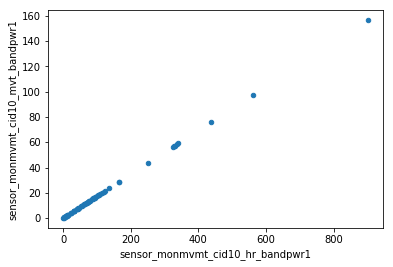

In [532]:
rbp1 = dff[['sensor_monmvmt_cid10_hr_bandpwr1','sensor_monmvmt_cid10_mvt_bandpwr1']].replace(-999999,np.nan).dropna()
rbp1.plot.scatter('sensor_monmvmt_cid10_hr_bandpwr1','sensor_monmvmt_cid10_mvt_bandpwr1')
rbp1.head()

In [540]:
print('MVMT HR B1:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna().shape)
print('MVMT HR B2:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna().shape)
print('MVMT HR B3:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna().shape)
print('MVMT HR B4:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna().shape)
print('MVMT MVT B1:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr1.replace(-999999,np.nan).dropna().shape)
print('MVMT MVT B2:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr2.replace(-999999,np.nan).dropna().shape)
print('MVMT MVT B3:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr3.replace(-999999,np.nan).dropna().shape)
print('MVMT MVT B4:', dff.sensor_monmvmt_cid10_hr_relative_bandpwr4.replace(-999999,np.nan).dropna().shape)

MVMT HR B1: (65,)
MVMT HR B2: (65,)
MVMT HR B3: (65,)
MVMT HR B4: (65,)
MVMT MVT B1: (65,)
MVMT MVT B2: (65,)
MVMT MVT B3: (65,)
MVMT MVT B4: (65,)


In [543]:
print('MHR HR B1:', dff.sensor_monmhr_f1_mhr_bandpwr1.replace(-999999,np.nan).dropna().shape)
print('MHR HR B2:', dff.sensor_monmhr_f1_mhr_bandpwr2.replace(-999999,np.nan).dropna().shape)
print('MHR HR B3:', dff.sensor_monmhr_f1_mhr_bandpwr3.replace(-999999,np.nan).dropna().shape)
print('MHR HR B4:', dff.sensor_monmhr_f1_mhr_bandpwr4.replace(-999999,np.nan).dropna().shape)

MHR HR B1: (84,)
MHR HR B2: (84,)
MHR HR B3: (84,)
MHR HR B4: (84,)


In [548]:
print('MHR HR & MVMT HR B1:', dff[['sensor_monmhr_f1_mhr_bandpwr1','sensor_monmvmt_cid10_hr_relative_bandpwr1']].replace(-999999,np.nan).dropna().shape)
print('MHR HR & MVMT HR B2:', dff[['sensor_monmhr_f1_mhr_bandpwr2','sensor_monmvmt_cid10_hr_relative_bandpwr2']].replace(-999999,np.nan).dropna().shape)
print('MHR HR & MVMT HR B3:', dff[['sensor_monmhr_f1_mhr_bandpwr3','sensor_monmvmt_cid10_hr_bandpwr3']].replace(-999999,np.nan).dropna().shape)
print('MHR HR & MVMT HR B3:', dff[['sensor_monmhr_f1_relative_bandpwr4','sensor_monmvmt_cid10_hr_bandpwr4']].replace(-999999,np.nan).dropna().shape)


MHR HR & MVMT HR B1: (65, 2)
MHR HR & MVMT HR B2: (65, 2)
MHR HR & MVMT HR B3: (65, 2)
MHR HR & MVMT HR B3: (65, 2)


In [552]:
dff.sensor_toi_f1_mvt_pwr_mvt21.replace(-999999,np.nan).dropna().shape

(1853,)

In [553]:
dff[['sensor_monmhr_f1_mhr_bandpwr1','sensor_monmvmt_cid10_hr_relative_bandpwr1','sensor_toi_f1_mvt_pwr_mvt21']].replace(-999999,np.nan).dropna().shape

(52, 3)

### Toitu Stuff
You can certainly make the case here for only using 
* band21
* band31

This is b/c (i) band21 and band31 are nearly orthogonal (corr: -0.04), whereas both band21 and band31
are better than 0.5 correlated w/t band41 (which is interesting, considering their nigh orthogonality).

In [504]:
print('Toitu band21 vs Toitu band31:', pearsonr(dff.sensor_toi_f1_mvt_pwr_mvt21.replace(-999999,np.nan).dropna(), dff.sensor_toi_f1_mvt_pwr_mvt31.replace(-999999,np.nan).dropna()))
print('Toitu band21 vs Toitu band41:', pearsonr(dff.sensor_toi_f1_mvt_pwr_mvt21.replace(-999999,np.nan).dropna(), dff.sensor_toi_f1_mvt_pwr_mvt41.replace(-999999,np.nan).dropna()))
print('Toitu band41 vs Toitu band31:', pearsonr(dff.sensor_toi_f1_mvt_pwr_mvt41.replace(-999999,np.nan).dropna(), dff.sensor_toi_f1_mvt_pwr_mvt31.replace(-999999,np.nan).dropna()))

Toitu band21 vs Toitu band31: (-0.041493218004514346, 0.07414768264542697)
Toitu band21 vs Toitu band41: (-0.6253388205878065, 1.2673568848040136e-201)
Toitu band41 vs Toitu band31: (-0.5233176997038518, 8.362851413614344e-131)


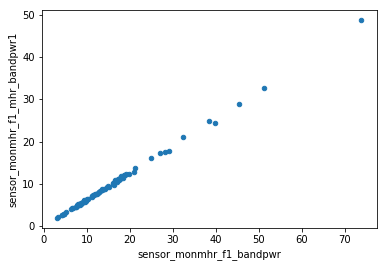

In [501]:
dff[['sensor_monmhr_f1_bandpwr', 'sensor_monmhr_f1_mhr_bandpwr1']].\
    replace(-999999,np.nan).\
    dropna().plot.scatter('sensor_monmhr_f1_bandpwr', 'sensor_monmhr_f1_mhr_bandpwr1')

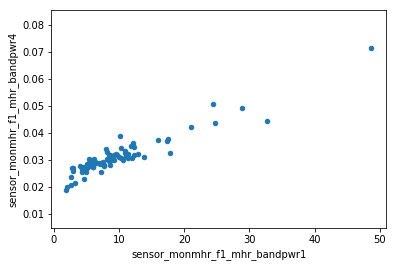

In [502]:
dff[['sensor_monmhr_f1_mhr_bandpwr1', 'sensor_monmhr_f1_mhr_bandpwr4']].\
    replace(-999999,np.nan).\
    dropna().plot.scatter('sensor_monmhr_f1_mhr_bandpwr1', 'sensor_monmhr_f1_mhr_bandpwr4')

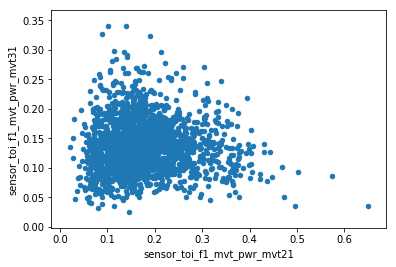

In [503]:
dff[['sensor_toi_f1_mvt_pwr_mvt21', 'sensor_toi_f1_mvt_pwr_mvt31']].\
    replace(-999999,np.nan).\
    dropna().plot.scatter('sensor_toi_f1_mvt_pwr_mvt21', 'sensor_toi_f1_mvt_pwr_mvt31')

# BAND POWER SUMMARY

MHR:
* BP bands 2 and 3
* RBP band 1, 3, 4
MVMT HR 
* BP bands 1, 3, 4 or just bands 1, 3
* RBP band 3
MVMT MVT (if not using MVMT HR) 
* BP bands 1, 3, 4 or just bands 1, 3
* RBP band 3

MVMT Band Powers:  Only 65 patients!

MHR Band Powers only constitute 84 patients.

Fortunately, 65 of those 84 MHR patients are the same 65 MVMT patients.


In [ ]:
# Restricted Band Power Sets
mon_mhr_restricted_bandpwr = ['sensor_monmhr_f1_mhr_bandpwr2', 'sensor_monmhr_f1_mhr_bandpwr3']
mon_mhr_restricted_relative_bandpwr = [
    'sensor_monmhr_f1_mhr_relative_bandpwr1', 'sensor_monmhr_f1_mhr_relative_bandpwr3', 
    'sensor_monmhr_f1_mhr_relative_bandpwr4']
mon_mvmt_restricted_bandpwr = ['sensor_monmvmt_cid10_hr_bandpwr1', 'sensor_monmvmt_cid10_hr_bandpwr3']
mon_mvmt_restricted_relative_bandpwr = ['mon_mvmt_restricted_relative_bandpwr3']



# Remove Monica Data Quality Vars
I left in a bunch of data quality vars in the Monica RMSSD data set... These should 
be removed: (i) the DQ is always at least decent (75% good data is lowest I saw);  (ii) not
sure a prediction should be predicated on a DQ variable (that said, I can imagine it
serving as an interaction variable, e.g., somehow dictates whether or not a tree should
trust a measurement).  I'll leave them out though...


In [475]:
rmssd_data_quality = [col for col in monica_cols 
                     if 'rwaves' in col
                     or 'perc' in col
                     or 'epoch' in col]
dff.drop(rmssd_data_quality, axis=1, inplace=True)

In [480]:
np.sort([col for col in monica_cols if 'band' in col and 'mvmt' in col and 'relative' not in col])

array(['sensor_monmvmt_cid10_hr_bandpwr',
       'sensor_monmvmt_cid10_hr_bandpwr1',
       'sensor_monmvmt_cid10_hr_bandpwr2',
       'sensor_monmvmt_cid10_hr_bandpwr3',
       'sensor_monmvmt_cid10_hr_bandpwr4',
       'sensor_monmvmt_cid10_mvt_bandpwr',
       'sensor_monmvmt_cid10_mvt_bandpwr1',
       'sensor_monmvmt_cid10_mvt_bandpwr2',
       'sensor_monmvmt_cid10_mvt_bandpwr3',
       'sensor_monmvmt_cid10_mvt_bandpwr4',
       'sensor_monmvmt_cid15_hr_bandpwr',
       'sensor_monmvmt_cid15_hr_bandpwr1',
       'sensor_monmvmt_cid15_hr_bandpwr2',
       'sensor_monmvmt_cid15_hr_bandpwr3',
       'sensor_monmvmt_cid15_hr_bandpwr4',
       'sensor_monmvmt_cid15_mvt_bandpwr',
       'sensor_monmvmt_cid15_mvt_bandpwr1',
       'sensor_monmvmt_cid15_mvt_bandpwr2',
       'sensor_monmvmt_cid15_mvt_bandpwr3',
       'sensor_monmvmt_cid15_mvt_bandpwr4',
       'sensor_monmvmt_cid20_hr_bandpwr',
       'sensor_monmvmt_cid20_hr_bandpwr1',
       'sensor_monmvmt_cid20_hr_bandpwr2',
      

# Prepare Feature Sets of Interest


### Sensor vs No Sensor
Simply put: does adding sensor data help any of the models?
* democlinical
* sensor
* democlinical + sensor


### Monica Band Power Redundancy
Any time I created a "relative band power" variable set, I also
left the regular "band power" variables in the sensor data set.  A few things about this:
* the regular band power variables are considered low quality because the magnitudes
  can be dependent on device, device placement, and other conditions; this is why we create
  the relative band power quantities -- they strip out the arbitrariness in magnitude, while
  maintaining the morphology
* though the regular band power quantities contain some orthogonal information (e.g., assuming
  the artifact effects aren't too big, then the magnitude information would indeed be orthogonal
  to the relative band powers and so would be an important consideration in a model), it is likely
  that they contain a lot of correlated information to the relative band powers -- and, if so, would
  reduce the variable importances for both sets of variables ("importance sharing")

In the models I develop, I should always have:
* a BP model
* a RBP model
* a BP+RBP model 

However, as far as I'm currently aware, the RBP model would be the most trustworthy.  If we see
much better results with the BP model, then we should consult further with Columbia to discern whether
it's worth caring about (or somehow just a spurious result).

Total Power:  when creating the relative band power quantities, I first defined "total band power"
quantities that I also left in the variable set.  If these spectral powers follow power-law distributions,
then this quantity very likely is highly correlated with the lowest frequency band, thus should
be discarded to avoid "importance sharing".  However, I did check these quantities (printed above
this cell) and there actually is fairly big difference between the quantities...

Note that for Toitu data, we only have proportional band powers (bands 2-4 proportional to 
band 1, e.g., band21 = band2/band1).  So we will not have an exploration space here for Toitu
band powers...


### Toitu vs Monica
We are also interested in the relative performances of the two different sensors that
were used to collect data.  So for each scenario, we should have:
* a Toitu model
* a Monica model
* a Toitu+Monica model

### Reality vs Wishes
In reality, at 25 weeks, the clinician does not have any F3 data in hand, which basically
means we cannot use the majority of the data set.  Would be nice though, right?  One thing
we can do is restrict the base population to only those people who have good F3 data (e.g.,
have a bunch of band power data), assume the data was taken around 25 weeks, and see if it
helps predict GA.   
* F1 model @ 25 wks (base population)
* F1+F3 model @ 25wks (restricted population)

Note that for the restricted F3 population, a 28wk binary classification model no longer makes
sense -- nor does the binned regresion model.  This is because the entire population will necessarily
be women who had not yet given birth at 34 weeks and beyond.  So we could do a regular
GA regression model, and then maybe a binary classification before/after 36 weeks.  

## The F1 Feature Sets
We have 3 base feature sets (dc, s, dc+s), 3 band power set (bp, rbp, bp+rbp), and
3 sensor breakdowns (t, m, t+m).  This means we have 3*3*3=27 feature sets.
1. democlinical, BP, Toitu
2. democlinical, BP, Monica
3. democlinical, BP, Toitu+Monica
4. democlinical, RBP, Toitu
5. democlinical, RBP, Monica
6. democlinical, RBP, Toitu+Monica
7. democlinical, BP+RBP, Toitu
8. democlinical, BP+RBP, Monica
9. democlinical, BP+RBP, Toitu+Monica
10. sensor, BP, Toitu
11. sensor, BP, Monica
12. sensor, BP, Toitu+Monica
13. sensor, RBP, Toitu
14. sensor, RBP, Monica
15. sensor, RBP, Toitu+Monica
16. sensor, BP+RBP, Toitu
17. sensor, BP+RBP, Monica
18. sensor, BP+RBP, Toitu+Monical
19. democlinical + sensor, BP, Toitu
20. democlinical + sensor, BP, Monica
21. democlinical + sensor, BP, Toitu+Monica
22. democlinical + sensor, RBP, Toitu
23. democlinical + sensor, RBP, Monica
24. democlinical + sensor, RBP, Toitu+Monica
25. democlinical + sensor, BP+RBP, Toitu
26. democlinical + sensor, BP+RBP, Monica
27. democlinical + sensor, BP+RBP, Toitu+Monica

For a model like a random forest, it's not clear that we really have to work through all
these iterations (probably can't hurt, but also likely unnecessary).  But... We'll do it
anyway to be thorough. 

## The F1+F3 Feature Sets
Basically, the same thing we did for the F1 feature sets.

## Define Feature Sets
Below, I define feature sets.  I've checked them all to ensure they are what
we would think they are, but to keep notebook clean, I deleted the cells that 
print out the various feature lists...  Feel free to re-check if you don't
trust me!  :-p

In [394]:
# Sensors
sensor_cols = [col for col in dff.columns if 'sensor' in col]

sensor_f1_cols = [col for col in sensor_cols 
                  if 'f1' in col or 'cid10' in col]

sensor_f2_cols = [col for col in sensor_cols 
                  if 'f2' in col or 'cid15' in col]

sensor_f3_cols = [col for col in sensor_cols 
                  if 'f3' in col or 'cid20' in col]

In [402]:
bandpwr_cols = [col for col in sensor_cols 
                if 'bandpwr' in col and 'relative' not in col]

relative_bandpwr_cols = [col for col in sensor_cols 
                if 'bandpwr' in col and 'relative' in col]

In [620]:
# TOITU
toitu_cols = [col for col in sensor_cols if 'toi' in col]

toitu_f1_cols = [col for col in toitu_cols if 'f1' in col]
toitu_f1_pwr_cols = [col for col in toitu_f1_cols if 'pwr' in col]

toitu_f2_cols = [col for col in toitu_cols if 'f2' in col]
toitu_f2_pwr_cols = [col for col in toitu_f2_cols if 'pwr' in col]

toitu_f3_cols = [col for col in toitu_cols if 'f3' in col]
toitu_f3_pwr_cols = [col for col in toitu_f3_cols if 'pwr' in col]


# MONICA
monica_cols = [col for col in sensor_cols if 'mon' in col]

# MONICA F1
monica_mhr_f1_cols = [col for col in monica_cols if 'mhr' in col and 'f1' in col]
monica_mvt_f1_cols = [col for col in monica_cols if 'mvt' in col and 'cid10' in col]
monica_mhr_f1_bandpwr = [
    'sensor_monmhr_f1_mhr_bandpwr1',  'sensor_monmhr_f1_mhr_bandpwr2',
    'sensor_monmhr_f1_mhr_bandpwr3', 'sensor_monmhr_f1_mhr_bandpwr4']
monica_mhr_f1_relative_bandpwr = [
    'sensor_monmhr_f1_relative_bandpwr1', 'sensor_monmhr_f1_relative_bandpwr2',
    'sensor_monmhr_f1_relative_bandpwr3', 'sensor_monmhr_f1_relative_bandpwr4']
monica_mvt_mvt_f1_bandpwr = [
    'sensor_monmvmt_f1_mvt_bandpwr1',  'sensor_monmvmt_f1_mvt_bandpwr2',
    'sensor_monmvmt_f1_mvt_bandpwr3', 'sensor_monmvmt_f1_mvt_bandpwr4']
monica_mvt_mvt_f1_relative_bandpwr = [
    'sensor_monmvmt_f1_mvt_relative_bandpwr1', 'sensor_monmvmt_f1_mvt_relative_bandpwr2',
    'sensor_monmvmt_f1_mvt_relative_bandpwr3', 'sensor_monmvmt_f1_mvt_relative_bandpwr4']
monica_mvt_hr_f1_bandpwr = [
    'sensor_monmvmt_f1_hr_bandpwr1',  'sensor_monmvmt_f1_hr_bandpwr2',
    'sensor_monmvmt_f1_hr_bandpwr3', 'sensor_monmvmt_f1_hr_bandpwr4']
monica_mvt_hr_f1_relative_bandpwr = [
    'sensor_monmvmt_f1_hr_relative_bandpwr1', 'sensor_monmvmt_f1_hr_relative_bandpwr2',
    'sensor_monmvmt_f1_hr_relative_bandpwr3', 'sensor_monmvmt_f1_hr_relative_bandpwr4']
monica_hr_f1_bandpwr = [
    'sensor_monmvmt_f1_hr_bandpwr1',  'sensor_monmhr_f1_hr_bandpwr2',
    'sensor_monmvmt_f1_hr_bandpwr3', 'sensor_monmhr_f1_hr_bandpwr4']
monica_hr_f1_relative_bandpwr = [
    'sensor_monmvmt_f1_relative_bandpwr1', 'sensor_monmhr_f1_relative_bandpwr2',
    'sensor_monmvmt_f1_relative_bandpwr3', 'sensor_monmhr_f1_relative_bandpwr4']


# Monica F2
monica_mhr_f2_cols = [col for col in monica_cols if 'mhr' in col and 'f2' in col]
monica_mvt_f2_cols = [col for col in monica_cols if 'mvt' in col and 'cid10' in col]

# Monica F2
monica_mhr_f3_cols = [col for col in monica_cols if 'mhr' in col and 'f3' in col]
monica_mvt_f3_cols = [col for col in monica_cols if 'mvt' in col and 'cid10' in col]


In [580]:
toitu_f1_pwr_cols

['sensor_toi_f1_mvt_pwr_mvt21',
 'sensor_toi_f1_mvt_pwr_mvt31',
 'sensor_toi_f1_mvt_pwr_mvt41']

In [ ]:
# Restricted Band Power Sets
mon_mhr_restricted_bandpwr = ['sensor_monmhr_f1_mhr_bandpwr2', 'sensor_monmhr_f1_mhr_bandpwr3']
mon_mhr_restricted_relative_bandpwr = [
    'sensor_monmhr_f1_mhr_relative_bandpwr1', 'sensor_monmhr_f1_mhr_relative_bandpwr3', 
    'sensor_monmhr_f1_mhr_relative_bandpwr4']
mon_mvmt_restricted_bandpwr = ['sensor_monmvmt_cid10_hr_bandpwr1', 'sensor_monmvmt_cid10_hr_bandpwr3']
mon_mvmt_restricted_relative_bandpwr = ['mon_mvmt_restricted_relative_bandpwr3']



# Populations

In [669]:
# 906
toitu_f1 = dff[toitu_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# 1853
toitu_f1_pwr = dff[toitu_f1_pwr_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# 389
toitu_f1f3 = dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# 389
toitu_f1f3_pwr = dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# Monica MHR
# 84
monica_mhr_f1 = dff[monica_mhr_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# 84
monica_mhr_f1_pwr = dff[monica_mhr_f1_relative_bandpwr].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# Monica MVMT HR
# 65
monica_mvt_f1 = dff[monica_mvt_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)


In [776]:
dff.loc[toitu_f1, toitu_f1_cols].head()

,sensor_toi_f1_hrmean1,sensor_toi_f1_hrmed1,sensor_toi_f1_hrstd1,sensor_toi_f1_medcc4,sensor_toi_f1_medlag4,sensor_toi_f1_mvt_pwr_mvt21,sensor_toi_f1_mvt_pwr_mvt31,sensor_toi_f1_mvt_pwr_mvt41
patid,,,,,,,,
S002-BISH-00002,148.92750,149.00250,3.252050,0.698840,-7.90,0.224079,0.129890,0.379089
S002-BISH-00017,155.60750,155.81350,1.734460,0.741684,-10.85,0.167577,0.133936,0.377544
S002-BISH-00041,150.19550,150.32650,2.549300,0.768195,-8.40,0.274003,0.068239,0.371595
S002-BISH-00044,152.47600,152.91000,3.422575,0.754286,-8.65,0.164736,0.131278,0.417863
S002-BISH-00065,138.32275,138.61975,1.676790,0.618115,-2.25,0.146088,0.118205,0.412565


In [638]:
toitu_f1_cols

['sensor_toi_f1_hrmean1',
 'sensor_toi_f1_hrmed1',
 'sensor_toi_f1_hrstd1',
 'sensor_toi_f1_medcc4',
 'sensor_toi_f1_medlag4',
 'sensor_toi_f1_mvt_pwr_mvt21',
 'sensor_toi_f1_mvt_pwr_mvt31',
 'sensor_toi_f1_mvt_pwr_mvt41']

# UPDATE
**Monday, 2020-01-13**

Spoke with Dani about all these issues
* models determining whether to use band power, relative bp, or both
* various populations (toitu, monica, toitu+monica)

Basically, she thinks the Monica data set (~60 patients) and the Toitu+Monical data
set (~50 patients) is useless -- she wouldn't trust the results.  This leaves us
with just the Toitu population (she also thought running a democlinical model of
the "base population" is useless since we can't compare it with a sensor model,
leaving us with the ~1800-patient Toitu population as our base population).

She also re-emphasized the regular band power is useless: even if it works, it
would only be spurious.  This is b/c the absolute values have a lot to do with
sensor placement, how tightly against the skin the sensor is, and so on.  Only
the relative band powers should be able to say anything...  Though I already knew
about these complaints about the regular band power quantities, I figured it would
be interesting to run those models anyway and see what happens -- but Dani is against
it (for the reason given above, namely any result would likely be spurious).

So this leaves us with 3 models:
* Democlinical Model on Toitu Population
* Toitu Model on Toitu Population
* Democlinical+Toitu Model on Toitu Population

Dani also agreed with my feature importance argument when looking at the 
correlation results:
* it is essential to remove some of the highly correlated band power quantities, lest
  they share importance and effectively get misplaced in the feature importance rankings
  list 
  - this can be resolved using something like "group permutation importance", but at the moment
    that seems like extra work with possibly no huge pay off...
 
### Correction: Population Sizes (2020-01-15)
When calculating the various populations, I counted incorrectly the other day.  For example, when I
was computing the size of the Toitu F1 population, I came to 1231; the size is really 906.  The discrepancy
arises from counting rows that are "all null" instead of those that have no nulls.  That is, 
* This: `dff[toitu_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==8).sum()`
* Instead of This: `dff[toitu_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0).sum()`


 
### Note2Self
Technically have to update the corresponding `.py` files with the various data processing
updates I've done.

In [751]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import auc, roc_auc_score, precision_score, average_precision_score, \
    accuracy_score, balanced_accuracy_score, recall_score, confusion_matrix
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt
%matplotlib inline

target_cols = [
    'adscmat_labortype_spontaneousoraugmented_db', 
    'adsc_dlvry_dt', 
    'adsc_dlvrybefore28wks', 
    'adsc_dlvrybefore34wks', 
    'adsc_dlvryga_dys', 
    'adsc_dlvryga_dys_sbadj'
]

# Get Full Dataset
dff = pd.read_csv('../data/processed/full_set_v4_20200110_KU.csv')

# Set PatId Index
dff.set_index('patid', inplace=True)

# Remove Cesareans/Inductions
dff.query('adscmat_labortype_spontaneousoraugmented_db == 1', inplace=True)

# Remove records w/ GA@Birth < 25 wks (168 days is last day of week 24, so let's do 170 for clean cut off)
dff.query('adsc_dlvryga_dys >= 170', inplace=True)

# NEW: Remove records w/ GA@Recruitment > 25 weeks
dff.query('adelig_ccga <= 170', inplace=True)
dff.drop('adelig_ccga', axis=1, inplace=True)


# Feature Subsets
#  -- Sensor Cols:       Monica and Toitu Cols (usually; we dropped Monica above)
#  -- Toitu Cols:        Toitu Cols
#  -- Toitu F1 Cols:     Toitu F1 Cols
#  -- Toitu F1 Pwr Cols: Toitu F1 Power Cols (band21, band31, band41)
democlinical_cols = [col for col in dff.columns if 'sensor' not in col]
sensor_cols = [col for col in dff.columns if 'sensor' in col]
monica_cols = [col for col in sensor_cols if 'mon' in col]
toitu_cols = [col for col in sensor_cols if 'toi' in col]
toitu_f1_cols = [col for col in toitu_cols if 'f1' in col]
toitu_f1_pwr_cols = [col for col in toitu_f1_cols if 'pwr' in col]
toitu_f1_orthog_pwr_cols = [col for col in toitu_f1_pwr_cols if '41' not in col]
toitu_f3_cols = [col for col in toitu_cols if 'f3' in col]
toitu_f3_pwr_cols = [col for col in toitu_f3_cols if 'pwr' in col]


# NOTE: We are simply dropping all Monica Cols for this analysis
#rmssd_data_quality = [col for col in monica_cols 
#                     if 'rwaves' in col or 'perc' in col or 'epoch' in col]
#dff.drop(rmssd_data_quality, axis=1, inplace=True)
dff.drop(monica_cols, axis=1, inplace=True)



# Patient Subsets
#  -- Toitu F1 (906): patients with all 8 Toitu F1 vars
#  -- Toitu F1 Pwr (1853):  patients with all 3 Toitu F1 Power vars
#  -- Toitu F1 Orthog Power (1853):  patients with power bands 21 and 31
#  -- Toitu F1F3 (389): patients with all F1 and F3 vars
#  -- Toitu F1F3 Pwr (389):  patients with all F1 and F3 Power vars
toitu_f1_population = \
    dff[toitu_f1_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1_pwr_population = \
    dff[toitu_f1_pwr_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1_orthog_pwr_population = \
    dff[toitu_f1_orthog_pwr_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1f3_population = \
    dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)
toitu_f1f3_pwr_population = \
    dff[toitu_f1_cols+toitu_f3_cols].replace(-999999,np.nan).isnull().sum(axis=1).map(lambda x: x==0)

# Data Subsets (rows_cols_df)
##1
toif1_demo_df = dff.copy().loc[toitu_f1_pwr_population, democlinical_cols]
##2
toif1pwr_toif1pwr_df = dff.copy().loc[toitu_f1_pwr_population, target_cols + toitu_f1_pwr_cols]
##3
toif1pwr_demotoif1pwr_df = dff.copy().\
    loc[toitu_f1_pwr_population, democlinical_cols + toitu_f1_pwr_cols]

### EXTRAS: Only worth checking out if 3 pwr cols do well
toif1orthog_toif1orthog_df = dff.copy().\
    loc[toitu_f1_orthog_pwr_population, target_cols + toitu_f1_orthog_pwr_cols]
toif1orthog_demotoif1orthog_df = dff.copy().\
    loc[toitu_f1_orthog_pwr_population, democlinical_cols + toitu_f1_orthog_pwr_cols]

# toif1_demo_df: Democlincal Features on the Toitu F1 Population

In [703]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1_demo_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]]


# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print(target,'\n')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (634, 106)
x_val: (136, 106)
adsc_dlvryga_dys 

Trn RMSE: 5.286094355298912
Val RMSE: 15.681017467738801
-------------------
Trn MnAbsErr: 3.4783438485804417
Val MnAbsErr: 10.878529411764706
-------------------
Trn r2: 0.8718246648690033
Val r2: 0.1972748064872314


,x_col,gini_importance
1,adstai_t_anxiety,0.114554
2,alcsmk_t2_avecigs.wk,0.081051
3,alcsmk_t1_avecigs.wk,0.077521
4,advs_height,0.060141
5,adfetalgrowth_deviationindex,0.051177
6,admh_hxpt2,0.049404
7,adedin_edinburgh_raw_all-10-15-20_db,0.048201
8,adelig_mat_age,0.045758
9,adstai_s_anxiety,0.038416
10,alcsmk_t2_alc,0.036439


# toif1_demotoif1_df

In [711]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1_demotoif1_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]]


# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print(target,'\n')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (634, 114)
x_val: (136, 114)
adsc_dlvryga_dys 

Trn RMSE: 5.347118522945111
Val RMSE: 15.063214249601966
-------------------
Trn MnAbsErr: 3.6168296529968464
Val MnAbsErr: 10.518823529411764
-------------------
Trn r2: 0.8688481982734393
Val r2: 0.25928059393805913


,x_col,gini_importance
1,alcsmk_t2_avecigs.wk,0.076606
2,alcsmk_t1_avecigs.wk,0.061077
3,adstai_t_anxiety,0.059335
4,sensor_toi_f1_mvt_pwr_mvt21,0.057734
5,advs_height,0.051969
6,admh_hxpt2,0.050981
7,sensor_toi_f1_hrstd1,0.050659
8,sensor_toi_f1_medlag4,0.042026
9,adelig_mat_age,0.031877
10,adfetalgrowth_deviationindex,0.031204


# toif1pwr_toif1pwr_df: Toitu F1 Power Features on TF1P Population

In [708]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1pwr_toif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]]


# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print(target,'\n')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 3)
x_val: (278, 3)
adsc_dlvryga_dys 

Trn RMSE: 6.163383003528835
Val RMSE: 14.93097198983211
-------------------
Trn MnAbsErr: 4.088134926754048
Val MnAbsErr: 10.559690647482014
-------------------
Trn r2: 0.8401965548491526
Val r2: -0.3328096818304882


,x_col,gini_importance
1,sensor_toi_f1_mvt_pwr_mvt21,0.345786
2,sensor_toi_f1_mvt_pwr_mvt41,0.342393
3,sensor_toi_f1_mvt_pwr_mvt31,0.311822


In [715]:
(170, 203)

(170, 203)

In [717]:
(204, 238)

(204, 238)

In [718]:
(238,'inf')

(238, 'inf')

-----------------------
----------------------
------------------

# Binned Regression 
Here we bin the GA in day bins:  (170,203), (204,238), (280, inf)

## toif1_demo_df

In [771]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1_demo_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]]
# BIN THE TARGET
high_risk = y.query('adsc_dlvryga_dys >= 170 and adsc_dlvryga_dys <= 203').index
medium_risk = y.query('adsc_dlvryga_dys >= 204 and adsc_dlvryga_dys <= 238').index
low_risk = y.query('adsc_dlvryga_dys >= 239').index
y.loc[high_risk] = 0
y.loc[medium_risk] = 1
y.loc[low_risk] = 2

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, stratify=y_val, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)
ypr_trn = np.round(yp_trn)
ypr_val = np.round(yp_val)

# Model Metrics
print(target,'\n')
print('Regression Metrics')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))
print(target,'\n')
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, ypr_trn))
print('Val Accuracy:',accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, ypr_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, ypr_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, ypr_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, ypr_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, ypr_val))
print('-------------------')
# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/kevinurban/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kevinurban/miniconda3/lib/python3

x_trn: (1297, 106)
x_val: (278, 106)
adsc_dlvryga_dys 

Regression Metrics
Trn RMSE: 0.0849082229367815
Val RMSE: 0.20587591429385552
-------------------
Trn MnAbsErr: 0.026954510408635318
Val MnAbsErr: 0.06604316546762591
-------------------
Trn r2: 0.8716180615247814
Val r2: 0.32599300411522625
adsc_dlvryga_dys 

Classication Metrics
Trn Accuracy: 0.9961449498843485
Val Accuracy: 0.960431654676259
-------------------
Trn Bal Accuracy: 0.8484848484848485
Val Bal Accuracy: 0.3851714167699298
-------------------
Trn Precision Score: 0.9966803735115223
Val Precision Score: 0.9498783326280152
-------------------
Trn Recall Score: 0.9961449498843485
Val Recall Score: 0.960431654676259
-------------------
Trn Confusion:
 [[   6    5    0]
 [   0   31    0]
 [   0    0 1255]]
Val Confusion:
 [[  0   2   1]
 [  0   1   5]
 [  0   3 266]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,alcsmk_t2_alc,0.076234
2,alcsmk_t1_avecigs.wk,0.070093
3,alcsmk_t2_avecigs.wk,0.067796
4,advs_height,0.055362
5,alcsmk_t1_alc,0.050281
6,admh_hxpt2,0.046959
7,adsmk_avgnumcighome,0.042121
8,adafppappa_afpmom,0.040231
9,advs_prepregbmi,0.039715
10,alcsmk_bt2,0.037328


## toif1pwr_toif1pwr_df

In [772]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1pwr_toif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]].copy()
# BIN THE TARGET
high_risk = y.query('adsc_dlvryga_dys >= 170 and adsc_dlvryga_dys <= 203').index
medium_risk = y.query('adsc_dlvryga_dys >= 204 and adsc_dlvryga_dys <= 238').index
low_risk = y.query('adsc_dlvryga_dys >= 239').index
y.loc[high_risk] = 0
y.loc[medium_risk] = 1
y.loc[low_risk] = 2

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, stratify=y_val, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)
ypr_trn = np.round(yp_trn)
ypr_val = np.round(yp_val)

# Model Metrics
print(target,'\n')
print('Regression Metrics')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))
print(target,'\n')
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, ypr_trn))
print('Val Accuracy:',accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, ypr_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, ypr_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, ypr_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, ypr_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, ypr_val))
print('-------------------')

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 3)
x_val: (278, 3)
adsc_dlvryga_dys 

Regression Metrics
Trn RMSE: 0.09297780801538712
Val RMSE: 0.2627914620340349
-------------------
Trn MnAbsErr: 0.029344641480339256
Val MnAbsErr: 0.07723021582733813
-------------------
Trn r2: 0.8460559058285521
Val r2: -0.09818580246913577
adsc_dlvryga_dys 

Classication Metrics
Trn Accuracy: 0.9915188897455667
Val Accuracy: 0.9640287769784173
-------------------
Trn Bal Accuracy: 0.6666666666666666
Val Bal Accuracy: 0.33209417596034696
-------------------
Trn Precision Score: 0.9852590226530087
Val Precision Score: 0.9361867906396905
-------------------
Trn Recall Score: 0.9915188897455667
Val Recall Score: 0.9640287769784173
-------------------
Trn Confusion:
 [[   0   11    0]
 [   0   31    0]
 [   0    0 1255]]
Val Confusion:
 [[  0   0   3]
 [  0   0   6]
 [  0   1 268]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,sensor_toi_f1_mvt_pwr_mvt31,0.344800
2,sensor_toi_f1_mvt_pwr_mvt41,0.335766
3,sensor_toi_f1_mvt_pwr_mvt21,0.319434


## toif1pwr_demotoif1pwr_df

In [773]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1pwr_demotoif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]].copy()
# BIN THE TARGET
high_risk = y.query('adsc_dlvryga_dys >= 170 and adsc_dlvryga_dys <= 203').index
medium_risk = y.query('adsc_dlvryga_dys >= 204 and adsc_dlvryga_dys <= 238').index
low_risk = y.query('adsc_dlvryga_dys >= 239').index
y.loc[high_risk] = 0
y.loc[medium_risk] = 1
y.loc[low_risk] = 2

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, stratify=y_val, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)
ypr_trn = np.round(yp_trn)
ypr_val = np.round(yp_val)

# Model Metrics
print(target,'\n')
print('Regression Metrics')
print('Trn RMSE:',np.sqrt(mean_squared_error(y_trn, yp_trn)))
print('Val RMSE:',np.sqrt(mean_squared_error(y_val, yp_val)))
print('-------------------')
print('Trn MnAbsErr:',mean_absolute_error(y_trn, yp_trn))
print('Val MnAbsErr:',mean_absolute_error(y_val, yp_val))
print('-------------------')
print('Trn r2:',r2_score(y_trn, yp_trn))
print('Val r2:',r2_score(y_val, yp_val))
print(target,'\n')
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, ypr_trn))
print('Val Accuracy:',accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, ypr_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, ypr_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, ypr_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, ypr_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, ypr_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, ypr_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, ypr_val))
print('-------------------')

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 109)
x_val: (278, 109)
adsc_dlvryga_dys 

Regression Metrics
Trn RMSE: 0.08265729380379476
Val RMSE: 0.2121693364700222
-------------------
Trn MnAbsErr: 0.026276021588280657
Val MnAbsErr: 0.07007194244604319
-------------------
Trn r2: 0.8783346833781466
Val r2: 0.2841557201646091
adsc_dlvryga_dys 

Classication Metrics
Trn Accuracy: 0.9946029298380878
Val Accuracy: 0.9640287769784173
-------------------
Trn Bal Accuracy: 0.787878787878788
Val Bal Accuracy: 0.3864105741429162
-------------------
Trn Precision Score: 0.995597126973177
Val Precision Score: 0.9506759427622735
-------------------
Trn Recall Score: 0.9946029298380878
Val Recall Score: 0.9640287769784173
-------------------
Trn Confusion:
 [[   4    7    0]
 [   0   31    0]
 [   0    0 1255]]
Val Confusion:
 [[  0   2   1]
 [  0   1   5]
 [  0   2 267]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,alcsmk_t2_alc,0.076368
2,sensor_toi_f1_mvt_pwr_mvt41,0.066606
3,alcsmk_t1_avecigs.wk,0.061786
4,alcsmk_t2_avecigs.wk,0.051083
5,sensor_toi_f1_mvt_pwr_mvt31,0.049929
6,advs_height,0.044784
7,sensor_toi_f1_mvt_pwr_mvt21,0.037366
8,admh_hxpt2,0.036837
9,alcsmk_t1_alc,0.033091
10,advs_prepregbmi,0.030404


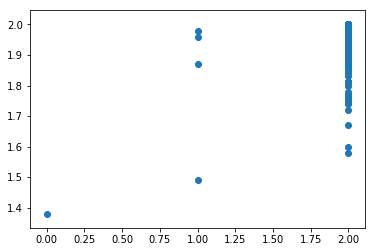

In [761]:
plt.scatter(y_val, yp_val);

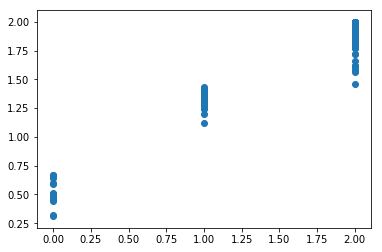

In [762]:
plt.scatter(y_trn, yp_trn);

# Binned Classification
Above, we tried two things for binned regression:
* regression with regression metrics
* regression-rounding with classification metrics

Here, instead of trying to regress, we treat the problem as a
classification problem.  

In [774]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1pwr_demotoif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets, axis=1)
y = data[[target]].copy()
# BIN THE TARGET
high_risk = y.query('adsc_dlvryga_dys >= 170 and adsc_dlvryga_dys <= 203').index
medium_risk = y.query('adsc_dlvryga_dys >= 204 and adsc_dlvryga_dys <= 238').index
low_risk = y.query('adsc_dlvryga_dys >= 239').index
y.loc[high_risk] = 0
y.loc[medium_risk] = 1
y.loc[low_risk] = 2

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, stratify=y_val, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, yp_trn))
print('Val Accuracy:',accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, yp_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, yp_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, yp_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, yp_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, yp_val))
print('-------------------')

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 109)
x_val: (278, 109)
Classication Metrics
Trn Accuracy: 1.0
Val Accuracy: 0.9676258992805755
-------------------
Trn Bal Accuracy: 1.0
Val Bal Accuracy: 0.3333333333333333
-------------------
Trn Precision Score: 1.0
Val Precision Score: 0.9362998809585426
-------------------
Trn Recall Score: 1.0
Val Recall Score: 0.9676258992805755
-------------------
Trn Confusion:
 [[  11    0    0]
 [   0   31    0]
 [   0    0 1255]]
Val Confusion:
 [[  0   0   3]
 [  0   0   6]
 [  0   0 269]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,alcsmk_t1_avecigs.wk,0.050658
2,alcsmk_t2_avecigs.wk,0.050477
3,advs_height,0.047086
4,adfetalgrowth_deviationindex,0.045994
5,sensor_toi_f1_mvt_pwr_mvt21,0.041319
6,sensor_toi_f1_mvt_pwr_mvt41,0.040778
7,sensor_toi_f1_mvt_pwr_mvt31,0.035752
8,advs_prepregbmi,0.035567
9,adstai_s_anxiety,0.035475
10,adsmk_avgnumcighome,0.034393


Notice that sensors are in positions 5, 6, and 7.  

We know that sensor band 41 is correlated with both 21 and 31, though
21 and 31 are basically not correlated.  We also know that correlated
variables tend to share importance, thus reducing the perceived importances
of each.  

So!  Let's remove sensor band 41 and see what happens.  

(Spoiler:  band21 moves from position 5 to position 4, while band31 moves from position 7 to position 6.)

In [778]:
# INPUTS
target = 'adsc_dlvryga_dys'
data = toif1pwr_demotoif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1)
y = data[[target]].copy()
# BIN THE TARGET
high_risk = y.query('adsc_dlvryga_dys >= 170 and adsc_dlvryga_dys <= 203').index
medium_risk = y.query('adsc_dlvryga_dys >= 204 and adsc_dlvryga_dys <= 238').index
low_risk = y.query('adsc_dlvryga_dys >= 239').index
y.loc[high_risk] = 0
y.loc[medium_risk] = 1
y.loc[low_risk] = 2

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
x_val, x_tst, y_val, y_tst = train_test_split(x_val, y_val,  test_size=0.5, stratify=y_val, random_state=29)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, yp_trn))
print('Val Accuracy:',accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, yp_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, yp_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, yp_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, yp_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, yp_val))
print('-------------------')

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 108)
x_val: (278, 108)
Classication Metrics
Trn Accuracy: 1.0
Val Accuracy: 0.9676258992805755
-------------------
Trn Bal Accuracy: 1.0
Val Bal Accuracy: 0.3333333333333333
-------------------
Trn Precision Score: 1.0
Val Precision Score: 0.9362998809585426
-------------------
Trn Recall Score: 1.0
Val Recall Score: 0.9676258992805755
-------------------
Trn Confusion:
 [[  11    0    0]
 [   0   31    0]
 [   0    0 1255]]
Val Confusion:
 [[  0   0   3]
 [  0   0   6]
 [  0   0 269]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,alcsmk_t1_avecigs.wk,0.052078
2,alcsmk_t2_avecigs.wk,0.047806
3,advs_height,0.044249
4,sensor_toi_f1_mvt_pwr_mvt21,0.041451
5,adfetalgrowth_deviationindex,0.039540
6,sensor_toi_f1_mvt_pwr_mvt31,0.038393
7,adelig_mat_age,0.037899
8,adstai_s_anxiety,0.036823
9,adedin_edinburgh_raw_all-10-15-20_db,0.035570
10,adstai_t_anxiety,0.034927


# 28 Week Binary?

In [780]:
targets

['adscmat_labortype_spontaneousoraugmented_db',
 'adsc_dlvry_dt',
 'adsc_dlvrybefore28wks',
 'adsc_dlvrybefore34wks',
 'adsc_dlvryga_dys',
 'adsc_dlvryga_dys_sbadj']

In [784]:
# INPUTS
target = 'adsc_dlvrybefore34wks'
data = toif1pwr_demotoif1pwr_df
#------------------------------------------------------

# Define Scenario Data (only Demo/Clinical)
x = data.drop(targets+['sensor_toi_f1_mvt_pwr_mvt41'], axis=1)
y = data[[target]].copy()

# Only keep records with non-missing target value
valid_target_index = y[target].replace(-999999, np.nan).dropna().index
x = x.loc[valid_target_index,:]
y = y.loc[valid_target_index,:]

# Split Data
x_trn, x_val, y_trn, y_val = train_test_split(x, y, train_size=0.7, stratify=y, random_state=23)
print('x_trn:',x_trn.shape)
print('x_val:',x_val.shape)


# Fit Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(x_trn, y_trn.values.ravel())

# Make Predictions
yp_trn = rf.predict(x_trn)
yp_val = rf.predict(x_val)

# Model Metrics
print('Classication Metrics')
print('Trn Accuracy:',accuracy_score(y_trn, yp_trn))
print('Val Accuracy:',accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn Bal Accuracy:',balanced_accuracy_score(y_trn, yp_trn))
print('Val Bal Accuracy:',balanced_accuracy_score(y_val, yp_val))
print('-------------------')
print('Trn AUROC:',roc_auc_score(y_trn, yp_trn))
print('Val AUROC:',roc_auc_score(y_val, yp_val))
print('-------------------')
print('Trn AUROC:',average_precision_score(y_trn, yp_trn))
print('Val AUROC:',average_precision_score(y_val, yp_val))
print('-------------------')
print('Trn Precision Score:',precision_score(y_trn, yp_trn, average='weighted'), )
print('Val Precision Score:',precision_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Recall Score:',recall_score(y_trn, yp_trn, average='weighted'), )
print('Val Recall Score:',recall_score(y_val, yp_val, average='weighted'))
print('-------------------')
print('Trn Confusion:\n',confusion_matrix(y_trn, yp_trn), )
print('Val Confusion:\n',confusion_matrix(y_val, yp_val))
print('-------------------')

# Gini Importances
imp = zip(x_trn.columns, rf.feature_importances_)
pd.DataFrame(imp, columns=['x_col','gini_importance']).\
    sort_values(by='gini_importance',ascending=False).\
    set_index(pd.Index(range(1,len(x_trn.columns)+1)))[:10]

/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


x_trn: (1297, 108)
x_val: (556, 108)
Classication Metrics
Trn Accuracy: 0.9992289899768697
Val Accuracy: 0.9694244604316546
-------------------
Trn Bal Accuracy: 0.9871794871794872
Val Bal Accuracy: 0.5
-------------------
Trn AUROC: 0.9871794871794872
Val AUROC: 0.5
-------------------
Trn AUROC: 0.9751299843821046
Val AUROC: 0.030575539568345324
-------------------
Trn Precision Score: 0.9992296023756172
Val Precision Score: 0.9397837844832048
-------------------
Trn Recall Score: 0.9992289899768697
Val Recall Score: 0.9694244604316546
-------------------
Trn Confusion:
 [[1258    0]
 [   1   38]]
Val Confusion:
 [[539   0]
 [ 17   0]]
-------------------


/Users/kevinurban/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,x_col,gini_importance
1,alcsmk_t2_avecigs.wk,0.069483
2,alcsmk_t1_avecigs.wk,0.069012
3,advs_height,0.047428
4,sensor_toi_f1_mvt_pwr_mvt21,0.043407
5,sensor_toi_f1_mvt_pwr_mvt31,0.042171
6,adstai_s_anxiety,0.039678
7,adfetalgrowth_deviationindex,0.038382
8,adelig_mat_age,0.037329
9,adstai_t_anxiety,0.035226
10,adsmk_avgnumcighome,0.030578


* auc
* roc_auc_score
* precision_score
* average_precision_score
* accuracy_score
* balanced_accuracy_score
* recall_score
* confusion matrix